The NREL S805 airfoil and the rest of the family have been specifically designed for use in wind turbines. The S805 has been studied at the Delft low-turbulence wind tunnel[1], including transition points and oil-flow photographs.

## Viiflow Parameters
The Delft low-turbulence wind tunnel is commonly used with a critical amplification factor of 11.2[2], but the transition locations are better matched by assuming a bit more turbulent conditions at 10.2. All calculations are performed with a Mach Number assuming a cord length of 0.5[1], no substeps are taken and the panel geometry has 200 points and a sharp trailing edge. The geometry is taken from the reference.

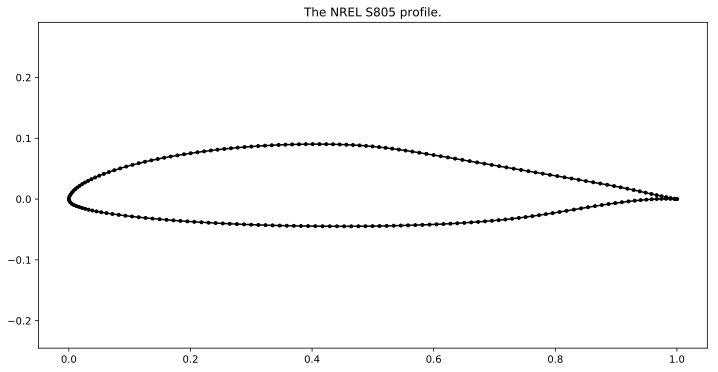

In [1]:
import viiflow as vf
import viiflowtools.vf_tools as vft
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import logging
logging.getLogger().setLevel(logging.WARNING)
matplotlib.rcParams['figure.figsize'] = [12, 6]

# Read Airfoil Data
N = 200
S805 = vft.repanel(vft.read_selig("S805.dat"),N)
plt.plot(S805[0,:],S805[1,:],'.-k')
plt.axis('equal');
plt.title('The NREL S805 profile.');


## Calculation

In [2]:
results = {} # Dictionary of results
AOARange = np.arange(-5,18.5,.5)
# Go over RE range
for RE in [5e5, 7e5, 10e5, 15e5, 20e5]:
#for RE in [5e5]:
    
    # Settings
    ncrit = 10.2
    Mach = 0.04*RE/5e5 # c = 0.5m, assuming 20°C
    s = vf.setup(Re=RE,Ma=Mach,ncrit=ncrit,alpha=AOARange[0],tolerance = 1e-3)
    s.silent = True

    # (Maximum) internal iterations
    s.itermax = 100

    results[RE] = {} # Sub-Dictionary of results
    results[RE]["AOA"] = []
    results[RE]["CL"] = []
    results[RE]["CD"] = []
    results[RE]["TRUP"] = []
    results[RE]["TRLO"] = []
    
    # Go over AOA range
    faults = 0
    init = True
    for alpha in AOARange:
        
        # Set current alpha and set res/grad to None to tell viiflow that they are not valid
        s.alpha = alpha
        res = None
        grad = None
        
        # Set-up and initialize based on inviscid panel solution
        # This calculates panel operator
        if init:
            [p,bl,x] = vf.init([S805],s)
            init = False

        # Run viiflow
        [x,flag,res,grad,_] = vf.iter(x,bl,p,s,res,grad)
        # If converged add to cl/cd vectors (could check flag as well, but this allows custom tolerance 
        # to use the results anyways)
        if flag:
            results[RE]["AOA"].append(alpha)
            results[RE]["CL"].append(p.CL)
            results[RE]["CD"].append(bl[0].CD)
            # Calculate transition position based on BL variable
            #results[RE]["TRUP"].append( \
            #    vft.interpLinear(p.foils[0].S,p.foils[0].X[0,:],bl[0].ST-bl[0].bl_fl.node_tr_up.xi[0]))
            #results[RE]["TRLO"].append( \
            #    vft.interpLinear(p.foils[0].S,p.foils[0].X[0,:],bl[0].ST+bl[0].bl_fl.node_tr_lo.xi[0]))
            results[RE]["TRUP"].append( \
                np.interp(bl[0].ST-bl[0].bl_fl.node_tr_up.xi[0],p.foils[0].S,p.foils[0].X[0,:]))
            results[RE]["TRLO"].append( \
                np.interp(bl[0].ST+bl[0].bl_fl.node_tr_lo.xi[0],p.foils[0].S,p.foils[0].X[0,:]))
            faults = 0
        else:
            faults+=1
            init = True
            
        # Skip current polar if 4 unconverged results in a row
        if faults>3:
            print("Meh")
            break


## Aerodynamic Polars
Both the experimental values and the viiflow calculations show that the design goal of a “laminar bucket” up to a lift coefficient of 0.9 is quite well achieved.

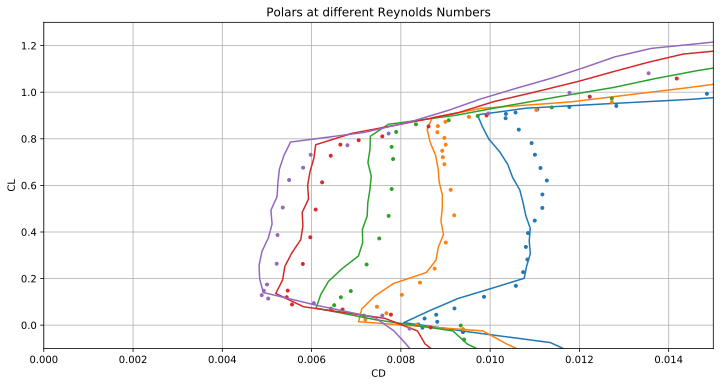

In [8]:
EXPRES=np.genfromtxt("S805Polars.csv",delimiter=",",names=True)
matplotlib.rcParams['figure.figsize'] = [12, 6]
fix,ax = plt.subplots(1,1)
ax.plot(results[5e5]["CD"],results[5e5]["CL"], color="tab:blue")
ax.plot(EXPRES['EXPPOLAR5_X'],EXPRES['EXPPOLAR5_Y'],marker=".",linestyle = 'None', color="tab:blue")

ax.plot(results[7e5]["CD"],results[7e5]["CL"],'tab:orange')
ax.plot(EXPRES['EXPPOLAR7_X'],EXPRES['EXPPOLAR7_Y'],marker=".", linestyle = 'None',color='tab:orange')

ax.plot(results[10e5]["CD"],results[10e5]["CL"],'tab:green')
ax.plot(EXPRES['EXPPOLAR10_X'],EXPRES['EXPPOLAR10_Y'],marker=".", linestyle = 'None',color='tab:green')

ax.plot(results[15e5]["CD"],results[15e5]["CL"],'tab:red')
ax.plot(EXPRES['EXPPOLAR15_X'],EXPRES['EXPPOLAR15_Y'],marker=".", linestyle = 'None',color='tab:red')

ax.plot(results[20e5]["CD"],results[20e5]["CL"],'tab:purple')
ax.plot(EXPRES['EXPPOLAR20_X'],EXPRES['EXPPOLAR20_Y'],marker=".", linestyle = 'None',color='tab:purple')

ax.set_xlabel('CD')
ax.set_ylabel('CL')
ax.set_xlim([0,0.015])
ax.set_ylim([-.1,1.3])
ax.grid(True)
ax.set_title("Polars at different Reynolds Numbers");

## Transition Location
The transition location behavior in shape and with respect to increasing Reynolds Number is generally well described by the computational results. At higher angles of attack, the calculations in general assume earlier transitions near the leading edge at high angles of attack. This, I assume, leads to lower maximum lift than calculated.

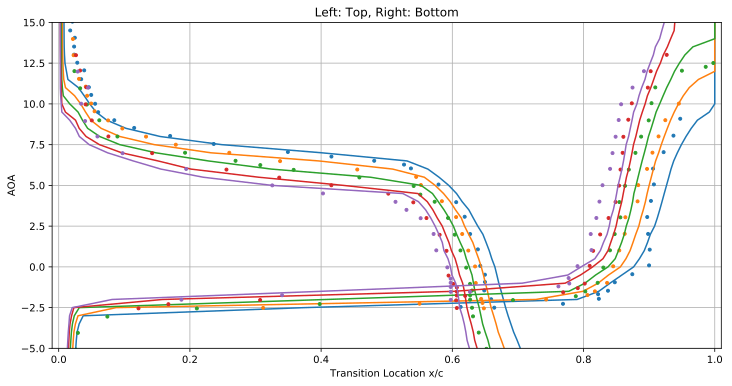

In [9]:
EXPRES=np.genfromtxt("S805TransitionLocations.csv",delimiter=",",names=True)
fix,ax = plt.subplots(1,1)
plt.plot(results[5e5]["TRUP"],results[5e5]["AOA"], color="tab:blue")
plt.plot(results[5e5]["TRLO"],results[5e5]["AOA"], color="tab:blue")
plt.plot(EXPRES['EXPBOTRE500_X'],EXPRES['EXPBOTRE500_Y'],marker=".",linestyle = 'None', color="tab:blue")
plt.plot(EXPRES['EXPTOPRE500_X'],EXPRES['EXPTOPRE500_Y'],marker=".",linestyle = 'None', color="tab:blue")

plt.plot(results[7e5]["TRUP"],results[7e5]["AOA"], color="tab:orange")
plt.plot(results[7e5]["TRLO"],results[7e5]["AOA"], color="tab:orange")
plt.plot(EXPRES['EXPBOTRE700_X'],EXPRES['EXPBOTRE700_Y'],marker=".",linestyle = 'None', color="tab:orange")
plt.plot(EXPRES['EXPTOPRE700_X'],EXPRES['EXPTOPRE700_Y'],marker=".",linestyle = 'None', color="tab:orange")

plt.plot(results[10e5]["TRUP"],results[10e5]["AOA"], color="tab:green")
plt.plot(results[10e5]["TRLO"],results[10e5]["AOA"], color="tab:green")
plt.plot(EXPRES['EXPBOTRE1000_X'],EXPRES['EXPBOTRE1000_Y'],marker=".",linestyle = 'None', color="tab:green")
plt.plot(EXPRES['EXPTOPRE1000_X'],EXPRES['EXPTOPRE1000_Y'],marker=".",linestyle = 'None', color="tab:green")

plt.plot(results[15e5]["TRUP"],results[15e5]["AOA"], color="tab:red")
plt.plot(results[15e5]["TRLO"],results[15e5]["AOA"], color="tab:red")
plt.plot(EXPRES['EXPBOTRE1500_X'],EXPRES['EXPBOTRE1500_Y'],marker=".",linestyle = 'None', color="tab:red")
plt.plot(EXPRES['EXPTOPRE1500_X'],EXPRES['EXPTOPRE1500_Y'],marker=".",linestyle = 'None', color="tab:red")

plt.plot(results[20e5]["TRUP"],results[20e5]["AOA"], color="tab:purple")
plt.plot(results[20e5]["TRLO"],results[20e5]["AOA"], color="tab:purple")
plt.plot(EXPRES['EXPBOTRE2000_X'],EXPRES['EXPBOTRE2000_Y'],marker=".",linestyle = 'None', color="tab:purple")
plt.plot(EXPRES['EXPTOPRE2000_X'],EXPRES['EXPTOPRE2000_Y'],marker=".",linestyle = 'None', color="tab:purple")

plt.xlabel('Transition Location x/c')
plt.ylabel('AOA')
plt.title('Left: Top, Right: Bottom')
plt.ylim([-5,15])
plt.xlim([-.01,1.01])
plt.grid(True)
plt.show()

## Lift Coefficients
The lift slope and zero lift angle of attack at low angles of attack, from -3° to 7°, is very good. Above 7°, the prediction and experiment diverge and lead to a disagreement in maximum lift coefficient and stall behavior. Although the maximum angle of attack is quite accurate.

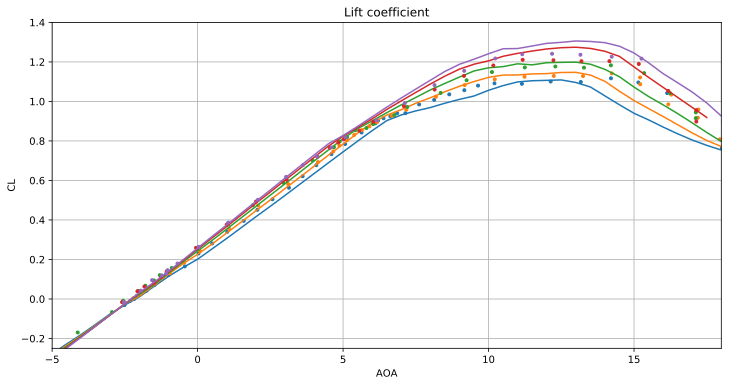

In [10]:
marker = None
fix,ax = plt.subplots(1,1)
EXPRES=np.genfromtxt("S805CL.csv",delimiter=",",names=True)
plt.plot(results[5e5]["AOA"],results[5e5]["CL"], marker=marker,color="tab:blue")
plt.plot(EXPRES['EXPRE500_X'],EXPRES['EXPRE500_Y'],marker=".",linestyle = 'None', color="tab:blue")

plt.plot(results[7e5]["AOA"],results[7e5]["CL"], marker=marker,color='tab:orange')
plt.plot(EXPRES['EXPRE700_X'],EXPRES['EXPRE700_Y'],marker=".", linestyle = 'None',color='tab:orange')

plt.plot(results[10e5]["AOA"],results[10e5]["CL"], marker=marker,color='tab:green')
plt.plot(EXPRES['EXPRE1000_X'],EXPRES['EXPRE1000_Y'],marker=".", linestyle = 'None',color='tab:green')

plt.plot(results[15e5]["AOA"],results[15e5]["CL"], marker=marker,color='tab:red')
plt.plot(EXPRES['EXPRE1500_X'],EXPRES['EXPRE1500_Y'],marker=".", linestyle = 'None',color='tab:red')

plt.plot(results[20e5]["AOA"],results[20e5]["CL"], marker=marker,color='tab:purple')
plt.plot(EXPRES['EXPRE2000_X'],EXPRES['EXPRE2000_Y'],marker=".", linestyle = 'None',color='tab:purple')

plt.xlabel('AOA')
plt.ylabel('CL')

plt.xlim([-5,18])
plt.ylim([-.25,1.4])
plt.grid(True)
plt.title("Lift coefficient")
plt.show()

## References

[1] D.Somers, *Design and Experimental Results for the S805 airfoil.* NREL/SR-440-6917

[2] Van Ingen, J. L. *The eN method for transition prediction: historical review of work at TU Delft.* AIAA, 2008.